# **"Гиперболические ИПСоиды"'s solution to [iMaterialist (Fashion) 2019 at FGVC6](https://www.kaggle.com/c/imaterialist-fashion-2019-FGVC6) completed as a selection task to INT20TH Hackathon**

### Setting up global variables and libraries

In [1]:
import os
import sys
import glob
import json
import random
from pathlib import Path
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from functools import partial
import itertools
from tqdm import tqdm

from imgaug import augmenters as iaa
from sklearn.model_selection import StratifiedKFold, KFold, train_test_split

In [2]:
import warnings 
warnings.filterwarnings("ignore")

In [3]:
DATA_PATH = os.path.abspath("data")
ROOT_PATH = os.path.abspath("")

We are choosing a 512x512 image size and ignoring class attributes, since they are difficult to predict and without them, the metrics are better. Besides, according to the host, 80% of images have no attributes at all. So we'll predict only classes

In [4]:
IMG_SIZE = 512
CLASS_NUM = 46

## Choosing model and downloading it's weights

We've looked through all the State of the Art solutions for Instance Segmentation and for this task we've chosen *Mask R-CNN* because:
* it's still considered as one of the STA solutions, despite the fact that it was published almost 2 years ago
* it's relatively light-weighted in comparison to other models
* we were able to train it on a custom data using kaggle kernels in quite a restricted time frame (other models, like *Hybrid Task Cascade with ResNeXt-101-64x4d-FPN*, would have taken an enormous time to train on kaggle

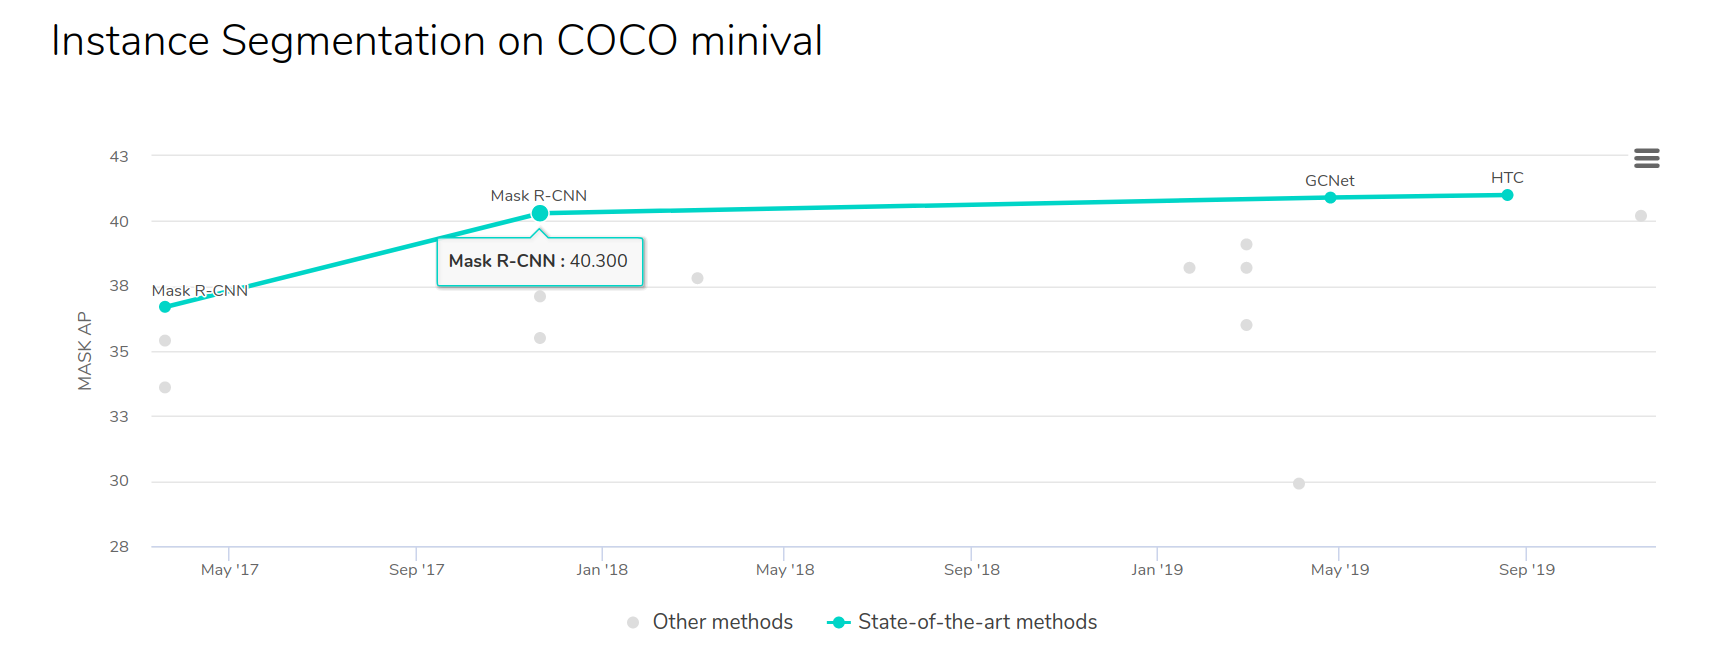

In [5]:
#clonning the model and it's pretrained on COCO dataset weights
#!git clone https://www.github.com/matterport/Mask_RCNN.git
#!wget https://github.com/matterport/Mask_RCNN/releases/download/v2.0/mask_rcnn_coco.h5

In [6]:
sys.path.append(str(ROOT_PATH + '/Mask_RCNN'))
initial_weights_path = ROOT_PATH + "/weights/mask_rcnn_coco.h5"

In [7]:
from mrcnn import utils
from mrcnn import visualize
from mrcnn.model import log
import mrcnn.model as modellib
from mrcnn.config import Config

Using TensorFlow backend.


## Creating configuration files

In [8]:
class TrainingConfig(Config):
    """Configuration used to train the model on Kaggle kernels"""
    NAME = "fashion"
    NUM_CLASSES = CLASS_NUM + 1
    
    GPU_COUNT = 1
    IMAGES_PER_GPU = 4
    
    BACKBONE = 'resnet50'
    
    IMAGE_MIN_DIM = IMG_SIZE
    IMAGE_MAX_DIM = IMG_SIZE    
    IMAGE_RESIZE_MODE = 'none'
    
    RPN_ANCHOR_SCALES = (16, 32, 64, 128, 256)
    
    STEPS_PER_EPOCH = 1000
    VALIDATION_STEPS = 200
    
config = TrainingConfig()
config.display()


Configurations:
BACKBONE                       resnet50
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     4
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 4
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  512
IMAGE_META_SIZE                59
IMAGE_MIN_DIM                  512
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              none
IMAGE_SHAPE                    [512 512   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE                

In [9]:
class TestingConfig(TrainingConfig):
    """Configuration used to test the model locally, using the pretrained weights"""
    IMAGES_PER_GPU = 1

testing_config = TestingConfig()

## Creating Datasets for the model

In [10]:
with open(DATA_PATH + "/label_descriptions.json") as file:
    label_descriptions = json.load(file)

label_names = [x['name'] for x in label_descriptions['categories']]

In [11]:
segment_df = pd.read_csv(DATA_PATH + "/train.csv")

In [12]:
segment_df['CategoryId'] = segment_df['ClassId'].str.split('_').str[0]  # 10(classId)_1_2_3(attributeIds) => 10
segment_df.sample(10)

,ImageId,EncodedPixels,Height,Width,ClassId,CategoryId
310980,f0e5c966260f017837198a9dd5920e10.jpg,427906 21 429005 23 430105 24 431204 27 432304...,1100,1100,33,33
3412,029e6e048cac753bba6ff3fa9eef603d.jpg,2702251 1 2706048 2 2709846 2 2713644 3 271744...,3798,2466,24,24
211852,a3fb503a987cdb15bd490878860d7673.jpg,771032 1 773381 3 775730 5 778080 6 780429 9 7...,2347,1000,35,35
176472,887fa24255751cee959f6929b2f1b84b.jpg,2483166 2 2486321 6 2489475 11 2492630 15 2495...,3156,2106,21,21
3093,02666b66d2419c9f004143c7a4299dcf.jpg,201473 6 201498 8 202193 6 202218 8 202235 2 2...,720,480,23,23
100493,4d602fff7aca065285290e6fbee22f45.jpg,2099091 4 2099113 6 2101517 10 2101539 12 2103...,2431,1500,17,17
30167,173da5c192cb7341e2f69eba37ffc959.jpg,182922 47 184116 80 185310 94 186504 107 18769...,1200,800,4_1_10_20_41_60_61_88,4
287831,dedbdb9bab480a55e127a0d5864ffccf.jpg,224495 24 225094 28 225694 31 226294 34 226893...,600,600,32,32
97064,4a9f2863e4bbf0e55ac91de651c100aa.jpg,264261 1 265060 4 265859 7 266658 10 267457 13...,800,640,33,33
319061,f6e378bd282aab7fbf22f9c240a79f92.jpg,158562 5 159642 15 160721 21 161801 20 162881 ...,1080,1080,24,24


As we see, one image may have multiple attributes. So we grup them up

In [13]:
segment_df = segment_df.set_index("ImageId")
train_idxs, test_idxs = train_test_split(np.unique(segment_df.index.values), test_size=0.2, random_state=42, shuffle=True)

train_df_raw = segment_df.loc[train_idxs]
test_df_raw = segment_df.loc[test_idxs]

In [14]:
train_image_df = train_df_raw.groupby('ImageId')['EncodedPixels', 'CategoryId'].agg(lambda x: list(x))
train_size_df = train_df_raw.groupby('ImageId')['Height', 'Width'].mean()
train_image_df = train_image_df.join(train_size_df, on='ImageId')

print("Total train images: ", len(train_image_df))
train_image_df.head()

Total train images:  36156


,EncodedPixels,CategoryId,Height,Width
ImageId,,,,
00000663ed1ff0c4e0132b9b9ac53f6e.jpg,[6068157 7 6073371 20 6078584 34 6083797 48 60...,"[6, 0, 28, 31, 32, 32, 31, 29, 4]",5214,3676
0002ec21ddb8477e98b2cbb87ea2e269.jpg,[2673735 2 2676734 8 2679734 13 2682733 19 268...,"[33, 10, 23, 23]",3000,1997
0002f5a0ebc162ecfb73e2c91e3b8f62.jpg,[435 132 1002 132 1569 132 2136 132 2703 132 3...,"[10, 33, 15]",567,400
00048c3a2fb9c29340473c4cfc06424a.jpg,[239016 3 239989 6 240963 7 241938 8 242913 9 ...,"[13, 1, 33, 8, 35, 24, 23, 23]",975,650
0006ea84499fd9a06fefbdf47a5eb4c0.jpg,[73327 6 74328 18 75330 37 76335 63 77340 88 7...,"[1, 33, 8, 23, 23]",1000,667


In [15]:
test_image_df = test_df_raw.groupby('ImageId')['EncodedPixels', 'CategoryId'].agg(lambda x: list(x))
test_size_df = test_df_raw.groupby('ImageId')['Height', 'Width'].mean()
test_image_df = test_image_df.join(test_size_df, on='ImageId')

print("Total test images: ", len(test_image_df))
test_image_df.head()

Total test images:  9039


,EncodedPixels,CategoryId,Height,Width
ImageId,,,,
0000fe7c9191fba733c8a69cfaf962b7.jpg,[2201176 1 2203623 3 2206071 5 2208518 8 22109...,"[33, 1]",2448,2448
0004467156e47b0eb6de4aa6479cbd15.jpg,[132663 8 133396 25 134130 41 134868 53 135611...,"[10, 33, 31, 31, 15]",750,500
000775b6b5e27b011dc8bba2d7b85211.jpg,[426259 9 427858 12 429457 14 431056 17 432655...,"[33, 1, 19, 6, 31, 31]",1600,1067
000cd2e13d1bdd28f480304d7bb9e1ca.jpg,[1522034 13 1525024 39 1528014 64 1531004 90 1...,"[1, 31, 28, 7, 35, 23, 23, 37, 37]",3000,2000
0017af9f7fa8ce9e7558bb924cec324e.jpg,[169688 9 171477 25 173265 43 175053 60 176841...,"[6, 1, 31, 31, 33]",1797,607


In [16]:
def resize_image(image_path):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE), interpolation=cv2.INTER_AREA)  
    return img

Redefining *utils.Dataset* for our use case

In [17]:
class FashionDataset(utils.Dataset):

    def __init__(self, df):
        super().__init__(self)
        
        # Add classes
        for i, name in enumerate(label_names):
            self.add_class("fashion", i+1, name)
        
        # Add images 
        for i, row in df.iterrows():
            self.add_image("fashion", 
                           image_id=row.name, 
                           path=str(DATA_PATH + '/train/'+ row.name), 
                           labels=row['CategoryId'],
                           annotations=row['EncodedPixels'], 
                           height=row['Height'], width=row['Width'])

    def image_reference(self, image_id):
        info = self.image_info[image_id]
        return info['path'], [label_names[int(x)] for x in info['labels']]
    
    def load_image(self, image_id):
        return resize_image(self.image_info[image_id]['path'])

    def load_mask(self, image_id):
        info = self.image_info[image_id]
                
        mask = np.zeros((IMG_SIZE, IMG_SIZE, len(info['annotations'])), dtype=np.uint8)
        labels = []
        
        for m, (annotation, label) in enumerate(zip(info['annotations'], info['labels'])):
            sub_mask = np.full(info['height']*info['width'], 0, dtype=np.uint8)
            annotation = [int(x) for x in annotation.split(' ')]
            
            for i, start_pixel in enumerate(annotation[::2]):
                sub_mask[start_pixel: start_pixel+annotation[2*i+1]] = 1

            sub_mask = sub_mask.reshape((info['height'], info['width']), order='F')
            sub_mask = cv2.resize(sub_mask, (IMG_SIZE, IMG_SIZE), interpolation=cv2.INTER_NEAREST)
            
            mask[:, :, m] = sub_mask
            labels.append(int(label)+1)
            
        return mask, np.array(labels)

Image and their masks examples 

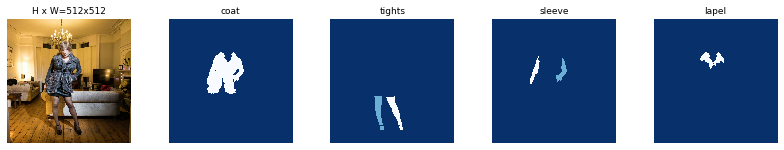

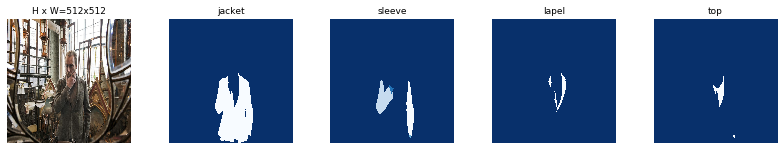

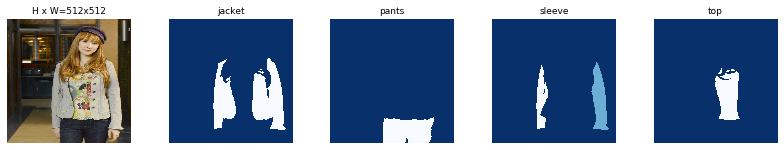

In [18]:
dataset = FashionDataset(train_image_df)
dataset.prepare()

for i in range(3):
    image_id = random.choice(dataset.image_ids)    
    image = dataset.load_image(image_id)
    mask, class_ids = dataset.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset.class_names, limit=4)

Partitioning data into train and validation sets. Since we can't validate our prediction using Kaggle, we'll calculate final validation score using 20% of the train data

In [19]:
# since we want to test our model on the data it never saw, we'll split it
train_df, valid_df = train_test_split(train_image_df, test_size=0.2, random_state=42, shuffle=True)

train_dataset = FashionDataset(train_df)
train_dataset.prepare()

valid_dataset = FashionDataset(valid_df)
valid_dataset.prepare()

Let's check the class distribution of the splitted datasets

Total train images:  28924
Total train segments:  212287


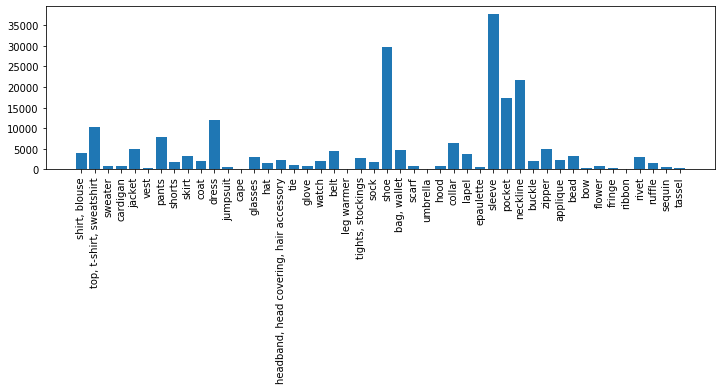

Total validation images:  7232
Total validation segments:  52662


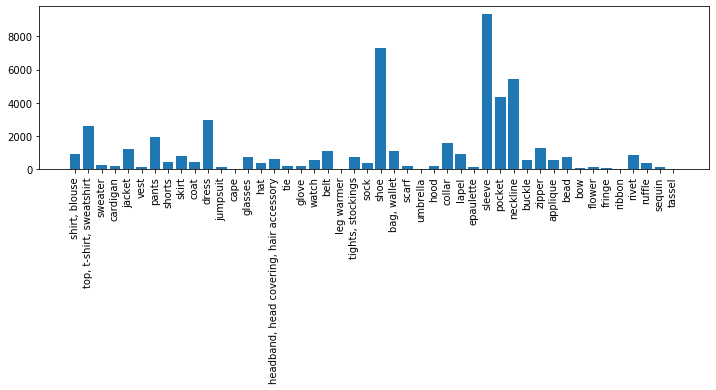

In [20]:
train_segments = np.concatenate(train_df['CategoryId'].values).astype(int)
print("Total train images: ", len(train_df))
print("Total train segments: ", len(train_segments))

plt.figure(figsize=(12, 3))
values, counts = np.unique(train_segments, return_counts=True)
plt.bar(values, counts)
plt.xticks(values, label_names, rotation='vertical')
plt.show()

valid_segments = np.concatenate(valid_df['CategoryId'].values).astype(int)
print("Total validation images: ", len(valid_df))
print("Total validation segments: ", len(valid_segments))

plt.figure(figsize=(12, 3))
values, counts = np.unique(valid_segments, return_counts=True)
plt.bar(values, counts)
plt.xticks(values, label_names, rotation='vertical')
plt.show()

# Train

Taking into account similarities between COCO and iMaterialist datasets, we've decided to use Transfer Learning and to use pre-trained weights of the Mask R-CNN model. We've trained only the top part of our model for 10 epochs. Because each epoch took more than 1 hour to finish, we did that is a few kernel sessions, gradually decreasing learning rate as we came closer to loss minimum. We used the following learning rate scheduler:
```
lr = 1e-2
if epochs > 6: 
    lr = lr ∗ 0.1 
if epochs > 8: 
    lr = lr ∗ 0.1 
if epochs == 10: 
    lr = lr ∗ 0.1```

In [21]:
weights_path = ROOT_PATH + "/weights/mask_rcnn_fashion_0010.h5"

To make our model more robust and diversify our dataset we've used image augmentations:

In [22]:
augmentation = iaa.Sequential([
    iaa.Fliplr(0.5), # horizontal flip
    iaa.Multiply((0.3, 1.2), per_channel=0.5), # change brightness of images (30-120% of original value)
    iaa.ContrastNormalization((0.3, 1.2), per_channel=0.5),
    iaa.Crop(percent=(0, 0.1)), # random crops
    iaa.arithmetic.JpegCompression((80, 90))
])

In [23]:
# model = modellib.MaskRCNN(mode='training', config=config, model_dir=ROOT_PATH)

# #loading weights from previous epoch
# model.load_weights(weights_path, by_name=True)

In [24]:
# model.train(train_dataset, valid_dataset,
#         learning_rate=lr,
#         epochs=epochs,
#         layers='heads',
#         augmentation=augmentation)

```Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDistributed)
mrcnn_mask_bn4         (TimeDistributed)
mrcnn_bbox_fc          (TimeDistributed)
mrcnn_mask_deconv      (TimeDistributed)
mrcnn_class_logits     (TimeDistributed)
mrcnn_mask             (TimeDistributed)
Epoch 8/10
1000/1000 [==============================] - 2440s 2s/step - loss: 2.8838 - rpn_class_loss: 0.1083 - rpn_bbox_loss: 1.0405 - mrcnn_class_loss: 0.5922 - mrcnn_bbox_loss: 0.5446 - mrcnn_mask_loss: 0.5982 - val_loss: 2.6346 - val_rpn_class_loss: 0.0930 - val_rpn_bbox_loss: 1.1380 - val_mrcnn_class_loss: 0.5197 - val_mrcnn_bbox_loss: 0.4304 - val_mrcnn_mask_loss: 0.4535
Epoch 9/10
1000/1000 [==============================] - 2095s 2s/step - loss: 2.4895 - rpn_class_loss: 0.1027 - rpn_bbox_loss: 0.9998 - mrcnn_class_loss: 0.4837 - mrcnn_bbox_loss: 0.4418 - mrcnn_mask_loss: 0.4615 - val_loss: 2.1939 - val_rpn_class_loss: 0.0790 - val_rpn_bbox_loss: 0.8786 - val_mrcnn_class_loss: 0.4575 - val_mrcnn_bbox_loss: 0.3915 - val_mrcnn_mask_loss: 0.3873
Epoch 10/10
1000/1000 [==============================] - 2224s 2s/step - loss: 2.4348 - rpn_class_loss: 0.1020 - rpn_bbox_loss: 1.0466 - mrcnn_class_loss: 0.4370 - mrcnn_bbox_loss: 0.4171 - mrcnn_mask_loss: 0.4320 - val_loss: 2.0614 - val_rpn_class_loss: 0.0791 - val_rpn_bbox_loss: 0.8100 - val_mrcnn_class_loss: 0.4405 - val_mrcnn_bbox_loss: 0.3720 - val_mrcnn_mask_loss: 0.3599
CPU times: user 26min 42s, sys: 2min 20s, total: 29min 3s
Wall time: 1h 55min 13s```

## Testing

In [25]:
model_path = ROOT_PATH + "/weights/mask_rcnn_fashion_0010.h5"

model = modellib.MaskRCNN(mode='inference', 
                          config=testing_config,
                          model_dir=ROOT_PATH)

assert model_path != '', "Provide path to trained weights"
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

W0123 18:21:04.826224 139749240723264 deprecation_wrapper.py:119] From /home/vzalevskyi/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0123 18:21:04.844401 139749240723264 deprecation_wrapper.py:119] From /home/vzalevskyi/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0123 18:21:04.847215 139749240723264 deprecation_wrapper.py:119] From /home/vzalevskyi/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0123 18:21:04.867755 139749240723264 deprecation_wrapper.py:119] From /home/vzalevskyi/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:1919: The name tf.nn.fused_batch_norm is deprecated. Please use tf.compat.

Loading weights from  /home/vzalevskyi/int20th_selection/weights/mask_rcnn_fashion_0010.h5


In [26]:
# Convert data to run-length encoding
def to_rle(bits):
    rle = []
    pos = 0
    for bit, group in itertools.groupby(bits):
        group_list = list(group)
        if bit:
            rle.extend([pos, sum(group_list)])
        pos += len(group_list)
    return rle

In [27]:
# Since the submission system does not permit overlapped masks, we have to fix them
def refine_masks(masks, rois):
    areas = np.sum(masks.reshape(-1, masks.shape[-1]), axis=0)
    mask_index = np.argsort(areas)
    union_mask = np.zeros(masks.shape[:-1], dtype=bool)
    for m in mask_index:
        masks[:, :, m] = np.logical_and(masks[:, :, m], np.logical_not(union_mask))
        union_mask = np.logical_or(masks[:, :, m], union_mask)
    for m in range(masks.shape[-1]):
        mask_pos = np.where(masks[:, :, m]==True)
        if np.any(mask_pos):
            y1, x1 = np.min(mask_pos, axis=1)
            y2, x2 = np.max(mask_pos, axis=1)
            rois[m, :] = [y1, x1, y2, x2]
    return masks, rois

In [46]:
# %%time
# sub_list = []
# missing_count = 0
# for i, row in enumerate(test_image_df.index.values):
    
#     image = resize_image(DATA_PATH + '/train/'+ row)
    
#     result = model.detect([image])[0]
    
#     if result['masks'].size > 0:
        
#         masks, _ = refine_masks(result['masks'], result['rois'])
#         for m in range(masks.shape[-1]):
            
#             mask = masks[:, :, m].ravel(order='F')
#             rle = to_rle(mask)
#             label = result['class_ids'][m] - 1
#             sub_list.append([row, ' '.join(list(map(str, rle))), label])
#     else:
#         # The system does not allow missing ids, this is an easy way to fill them 
#         sub_list.append([row, '1 1', 23])
#         missing_count += 1

In [47]:
# prediction_df = pd.DataFrame(sub_list, columns=sample_df.columns.values)
# print("Total image results: ", submission_df['ImageId'].nunique())
# print("Missing Images: ", missing_count)
# prediction_df.head()

In [48]:
# prediction_df.to_csv("submission.csv", index=False)

In [49]:
prediction_df = pd.read_csv("validation_prediction_e10.csv", index_col="ImageId").drop(columns=["Unnamed: 0"])

In [74]:
prediction_df = prediction_df.rename({"ClassId":"CategoryId"}, axis=1)
prediction_df.head()

,EncodedPixels,CategoryId
ImageId,,
708593d06ca574ed8f82e58de1546ed0.jpg,163821 4 164330 8 164840 10 165333 1 165347 15...,23
708593d06ca574ed8f82e58de1546ed0.jpg,163310 1 163819 2 163825 1 164329 1 164838 2 1...,23
708593d06ca574ed8f82e58de1546ed0.jpg,210692 3 211203 4 211715 4 212226 5 212666 14 ...,31
051304baf10af948afc409fed4e15be3.jpg,53945 6 54452 16 54960 23 55469 28 55978 33 56...,31
051304baf10af948afc409fed4e15be3.jpg,99780 6 99788 5 100291 16 100803 16 101317 14 ...,23


In [51]:
print("Masks detected:", len(prediction_df)) 
print("Images predicted:", len(np.unique(prediction_df.index.values)))

Masks detected: 53041
Images predicted: 9039


Let's visualise results!

In [114]:
pred_masks = []

8dc40383ed66fae60e48456a82898130.jpg


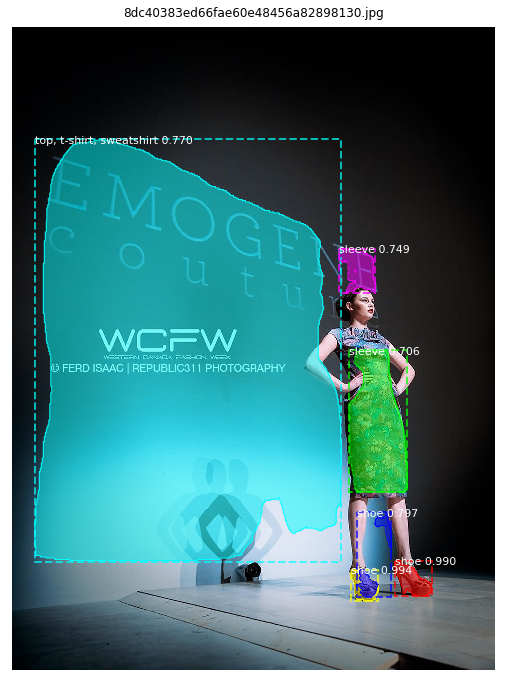

4507cdc25fe8925a9c047c64b21bcdb0.jpg


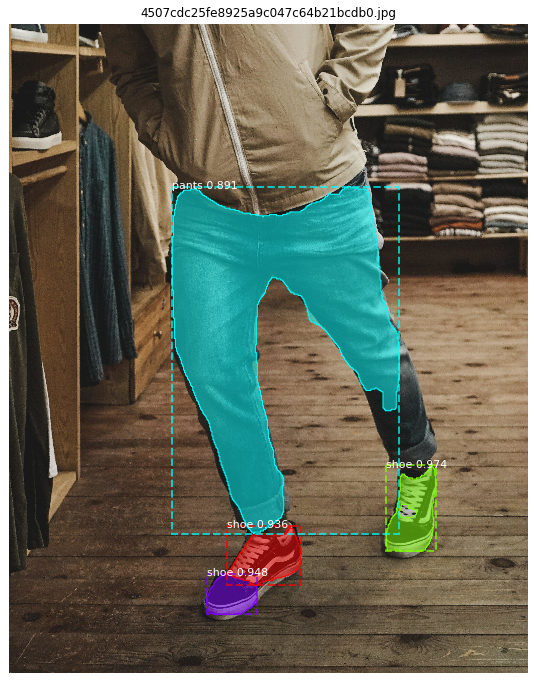

f3b8dc8e93e7cda96ecd4fd3c94f56e0.jpg


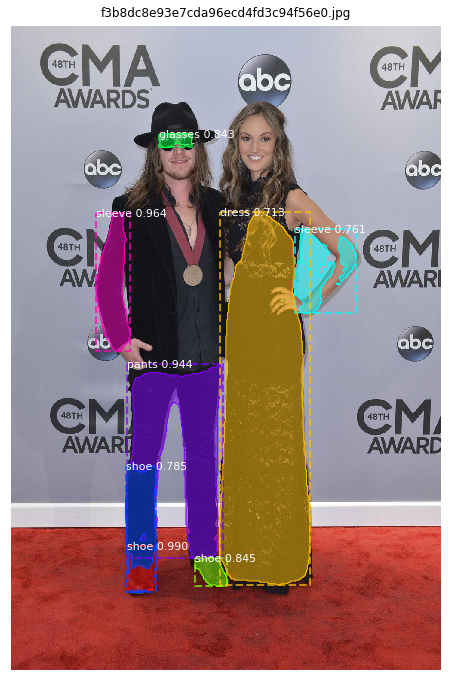

a7e9b7288b7ce2cd73d656c7df60ac05.jpg


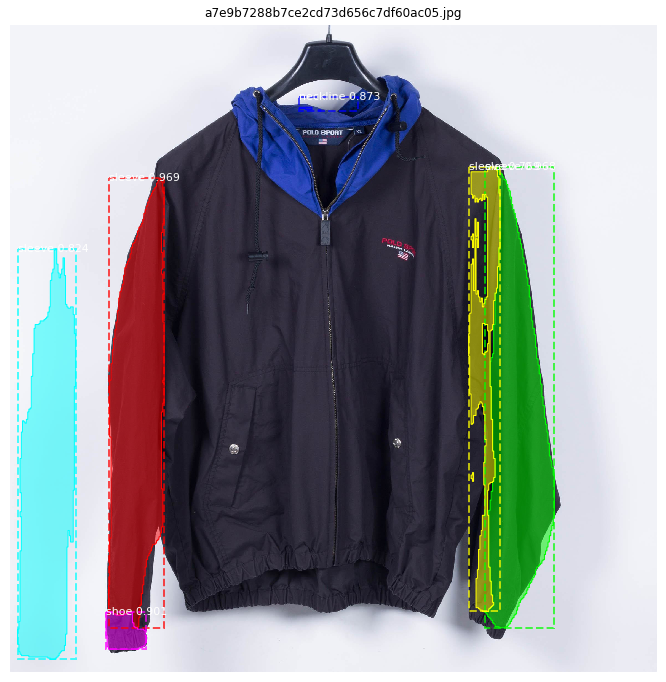

In [122]:
for i in range(4):
    image_id = prediction_df.sample().index.values[0]
    image_path = str(DATA_PATH + '/train/'+ image_id)
    
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    result = model.detect([resize_image(image_path)])
    r = result[0]
    
    if r['masks'].size > 0:
        masks = np.zeros((img.shape[0], img.shape[1], r['masks'].shape[-1]), dtype=np.uint8)
        for m in range(r['masks'].shape[-1]):
            masks[:, :, m] = cv2.resize(r['masks'][:, :, m].astype('uint8'), 
                                        (img.shape[1], img.shape[0]), interpolation=cv2.INTER_NEAREST)
        
        y_scale = img.shape[0]/IMG_SIZE
        x_scale = img.shape[1]/IMG_SIZE
        rois = (r['rois'] * [y_scale, x_scale, y_scale, x_scale]).astype(int)
        
        masks, rois = refine_masks(masks, rois)
    else:
        masks, rois = r['masks'], r['rois']
    
    pred_masks.append({image_id:masks})
    print(image_id)
    visualize.display_instances(img, rois, masks, r['class_ids'], 
                                ['bg']+label_names, r['scores'],
                                title=image_id, figsize=(12, 12))

In [139]:
some_res = pred_masks[-3]
print(some_res)

{'4507cdc25fe8925a9c047c64b21bcdb0.jpg': array([[[0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        ...,
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0]],

       [[0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        ...,
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0]],

       [[0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        ...,
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0]],

       ...,

       [[0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        ...,
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0]],

       [[0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        ...,
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0]],

       [[0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        ...,
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0]]], dtype=uint8)}


In [143]:
some_res['4507cdc25fe8925a9c047c64b21bcdb0.jpg'].shape

(3267, 2614, 4)

## Evaluating the model

In [103]:
def calc_IoU(A,B):
    AorB = np.logical_or(A,B).astype('int')
    AandB = np.logical_and(A,B).astype('int')
    IoU = AandB.sum() / AorB.sum()
    return IoU

def rle_to_mask(rle_list, SHAPE):
    tmp_flat = np.zeros(SHAPE[0]*SHAPE[1])
    if len(rle_list) == 1:
        mask = np.reshape(tmp_flat, SHAPE).T
    else:
        strt = rle_list[::2]
        length = rle_list[1::2]
        for i,v in zip(strt,length):
            tmp_flat[(int(i)-1):(int(i)-1)+int(v)] = 255
        mask = np.reshape(tmp_flat, SHAPE).T
    return mask

def calc_IoU_threshold(data):
    # Note: This rle_to_mask should be called before loop below for speed-up! We currently implement here to reduse memory usage.
    mask_gt = rle_to_mask(data['EncodedPixels_gt'].split(), (int(data['Height']), int(data['Width'])))
    mask_pred = rle_to_mask(data['EncodedPixels_pred'].split(), (int(data['Height']), int(data['Width'])))
    return calc_IoU(mask_gt, mask_pred)

def evaluation(gt_df, pred_df):
    eval_df = pd.merge(gt_df, pred_df, how='outer', on=['ImageId', 'CategoryId'], suffixes=['_gt', '_pred'])
    #return eval_df
    # IoU for True Positive
    idx_ = eval_df['EncodedPixels_gt'].notnull() & eval_df['EncodedPixels_pred'].notnull()
    IoU = eval_df[idx_].apply(calc_IoU_threshold, axis=1)

    # False Positive
    fp = (eval_df['EncodedPixels_gt'].isnull() & eval_df['EncodedPixels_pred'].notnull()).sum()

    # False Negative
    fn = (eval_df['EncodedPixels_gt'].notnull() & eval_df['EncodedPixels_pred'].isnull()).sum()

    threshold_IoU = [0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95]
    scores = []
    for th in threshold_IoU:
        # True Positive
        tp = (IoU > th).sum()
        maybe_fp = (IoU <= th).sum()

        # False Positive (not Ground Truth) + False Positive (under IoU threshold)
        fp_IoU = fp + maybe_fp

        # Calculate evaluation score
        score = tp / (tp + fp_IoU + fn)
        scores.append(score)
        print(f"Threshold: {th}, Precision: {score}, TP: {tp}, FP: {fp_IoU}, FN: {fn}")

    mean_score = sum(scores) / len(threshold_IoU)
    print(f"Mean precision score: {mean_score}")

In [108]:
len(gt_df.loc[selected_raws]) + len(prediction_df.loc[selected_raws])

13280

In [58]:
# Ground truth for our testing dataset
gt_rows = np.unique(prediction_df.index.values)

gt_columns = ['EncodedPixels', 'Height', 'Width', 'CategoryId']
gt_df = segment_df[gt_columns].loc[gt_rows]
gt_df.sample(10)

,EncodedPixels,Height,Width,CategoryId
ImageId,,,,
85fd05f51253e9f23a72da582e94946c.jpg,5034337 1 5038786 1 5043234 3 5047683 3 505213...,4450,2778,1
fb9bba48ac2cec5be459d97a33478bab.jpg,213368 4 213457 6 214083 10 214174 9 214798 16...,720,480,31
e6ab5e7afd192e6ae446b3638d08a98e.jpg,2676679 18 2679675 27 2682671 33 2685668 37 26...,3000,2000,28
ad6734c6c91f5921049d40fb18d99535.jpg,920729 14 922524 19 924321 22 926110 30 927891...,1800,1200,31
b24b8fbe6dd5105ca4da2621d5841e44.jpg,413977 3 415251 10 416526 16 417800 23 419061 ...,1280,852,31
5a28356dba1e62ef0bd1bc2d6e6f46c2.jpg,331454 9 332355 25 333255 42 333329 23 334155 ...,900,600,31
0d4e198f55d6d2f440274e6b99f6523e.jpg,450421 3 451615 9 452810 15 454005 20 455203 2...,1200,800,34
1a9e965678f9482cd10b00e634050cc5.jpg,1508677 3 1511173 6 1513668 10 1516163 14 1518...,2500,1663,1
c0a19f2e6169a5df0834afe7d5d9e5b2.jpg,1124846 4 1127102 11 1129359 16 1131615 22 113...,2261,1500,32


In [65]:
assert len(np.unique(prediction_df.index.values)) == len(np.unique(gt_df.index.values))

In [88]:
gt_df["CategoryId"] = gt_df["CategoryId"].astype("int64")

In [101]:
train_number = 100

selected_raws = np.random.choice(gt_rows, size=train_number)

In [102]:
%%time
evaluation(gt_df.loc[selected_raws], prediction_df.loc[selected_raws])

Threshold: 0.5, Precision: 0.0, TP: 0, FP: 9325, FN: 4028
Threshold: 0.55, Precision: 0.0, TP: 0, FP: 9325, FN: 4028
Threshold: 0.6, Precision: 0.0, TP: 0, FP: 9325, FN: 4028
Threshold: 0.65, Precision: 0.0, TP: 0, FP: 9325, FN: 4028
Threshold: 0.7, Precision: 0.0, TP: 0, FP: 9325, FN: 4028
Threshold: 0.75, Precision: 0.0, TP: 0, FP: 9325, FN: 4028
Threshold: 0.8, Precision: 0.0, TP: 0, FP: 9325, FN: 4028
Threshold: 0.85, Precision: 0.0, TP: 0, FP: 9325, FN: 4028
Threshold: 0.9, Precision: 0.0, TP: 0, FP: 9325, FN: 4028
Threshold: 0.95, Precision: 0.0, TP: 0, FP: 9325, FN: 4028
Mean precision score: 0.0
CPU times: user 4min 27s, sys: 3min 1s, total: 7min 29s
Wall time: 7min 28s
